# Seismic Transformer modular (out_of_date)

*Author: Jason Jiang (Xunfun Lee)*

*Date: 2023.12.1*

**Notes:** 
1. This notebook is an upgrade of SeT-Base.ipynb, make sure you know every detail of that notebook before you using this notebook.
2. This notebook depends on a lot of python scrip from the folder "PythonScripts". Actually, the notebook here is a modular factory to test vast parameter in order to find the best one. So a lot of detailed function definition in SeT-Base.ipynb is packaged into python script.

## Hyper-Parameters



In [1]:
# Data parameter
DATA_SOURCE = "50Hz_60s"
PATCH_SIZE = 250
NUM_OF_CLASSES = 5

# Transformer parameter
HIDDEN_SIZE = 384
NUM_HEAD = 6
NUM_LAYER = 6
DROPOUT_ATTENTION:float = 0.
DROPOUT_MLP:float = 0.1
DROPOUT_EMBED:float = 0.

# Training parameter
BATCH_SIZE = 64
NUM_EPOCH = 1
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.1

## 0. Dependency and Device

In [2]:
import torch

In [3]:
# device
if torch.cuda.is_available():
    device = "cuda"
    print("CUDA is available")
    print("CUDA device numbers: ", torch.cuda.device_count())
    !nvidia-smi
elif torch.backends.mps.is_available():
    device = "mps"
    print("MPS is available")
else:
    device = "cpu"
    print("No GPU found, using CPU")

device

CUDA is available
CUDA device numbers:  1
Sat Dec  2 15:39:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  Off |
|  0%   45C    P8    29W / 480W |   1301MiB / 24564MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                              

'cuda'

## 1. Data Preparation

Using functionality we create in the `Data_Preparation.py`

In [4]:
from PythonScripts.data_preparation import LoadData, H5pyToTensor

### 1.1 Load the data from matlab

Here the function turn h5py file to numpy array, then turn it into tensor.

In [5]:
file_name = "cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat"
traindata_path, valdata_path, testdata_path = LoadData(time_series=DATA_SOURCE,file_name=file_name)
train_data, train_labels, validation_data, validation_labels, test_data, test_labels = H5pyToTensor(traindata_path=traindata_path,valdata_path=valdata_path,testdata_path=testdata_path,transpose=True)

traindata_path: Data\50Hz_60s\train\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat
valdata_path: Data\50Hz_60s\validation\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat
testdata_path: Data\50Hz_60s\test\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat
--------------------------------
Length of train dataset(60940) --> label(60940)
Length of validation dataset(51725) --> label(51725)
Length of test dataset(1715) --> label(1715)
--------------------------------
Shape of train dataset(torch.Size([60940, 3000])) = 60940 GMs --> label(torch.Size([60940, 1]))
Shape of validation dataset(torch.Size([51725, 3000])) = 51725 GMs --> label(torch.Size([51725, 1]))
Shape of test dataset(torch.Size([1715, 3000])) = 1715 GMs --> label(torch.Size([1715, 1]))
--------------------------------


### 1.2* Check if the data look good :)

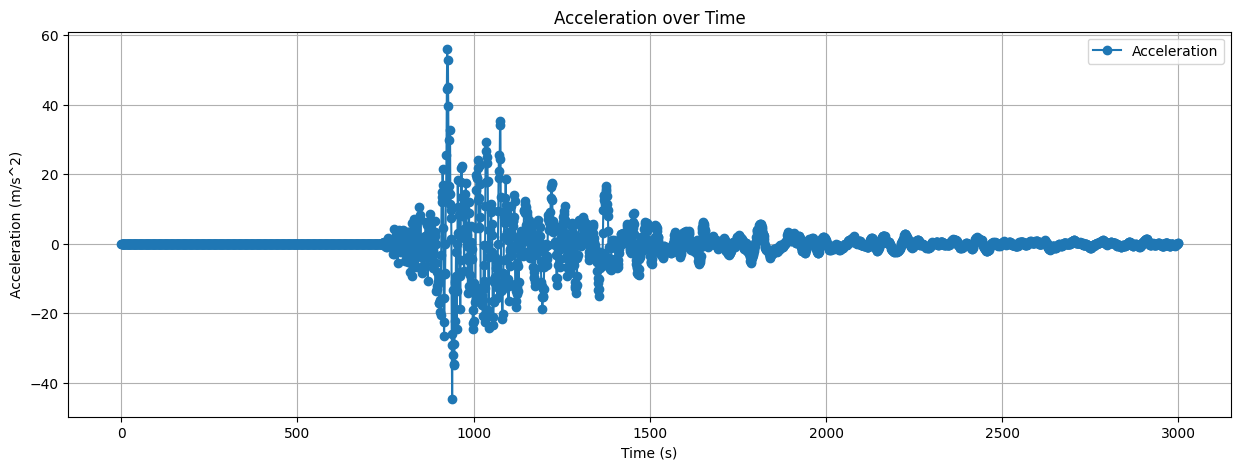

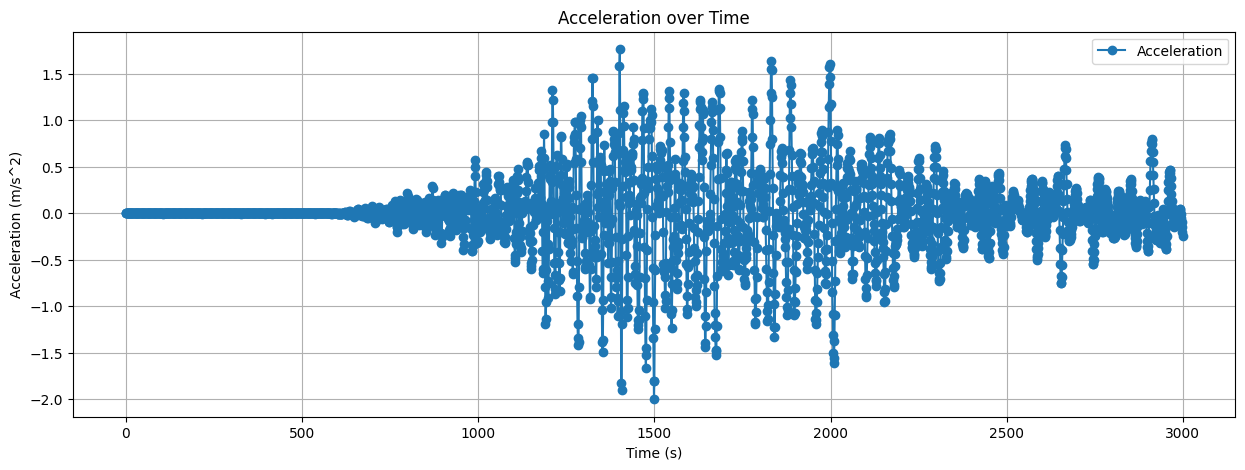

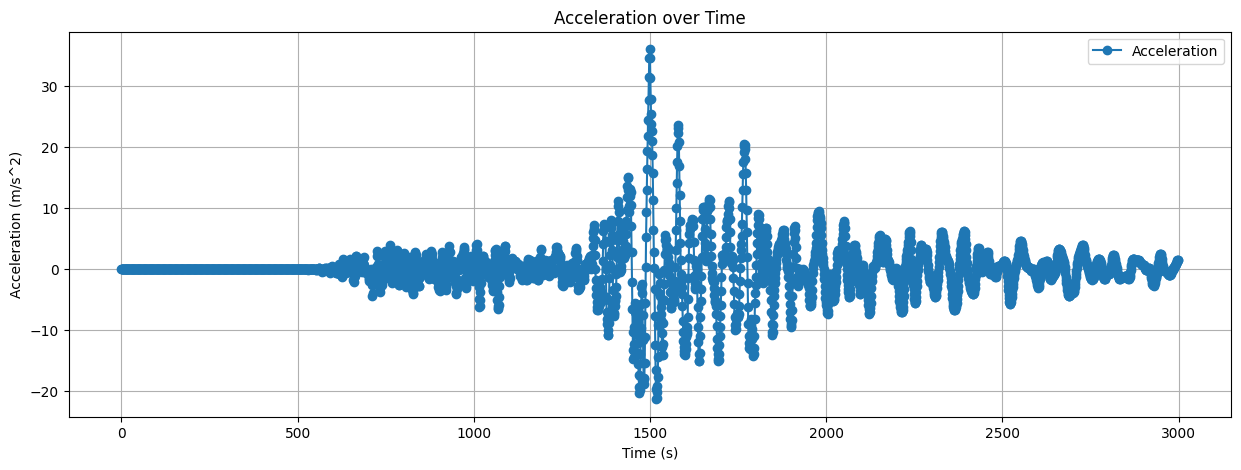

In [6]:
from PythonScripts.visualization import PlotManyGM

PlotManyGM(gm_timeseries_array=train_data, num_of_subplot=3, randomness=True)
# PlotManyGM(gm_timeseries_array=validation_data, num_of_subplot=3, randomness=True)
# PlotManyGM(gm_timeseries_array=test_data, num_of_subplot=3, randomness=True)

It seems that our data look really nice :)
Data process complete!

## 2. Create dataloader and embedding

Now that we have array of the ground motion in `tensor` type, now we have to put it into dataloader.

### 2.1 Modify the dimension of the data

In [7]:
# ground motion data: add an extra dimension to match the model input
# [num_of_gms, length_of_each_gm] ----> [num_of_gms, length_of_each_gm, 1]
train_data = train_data.unsqueeze(2)                        # [60940, 3000] --> [60940, 3000, 1]
validation_data = validation_data.unsqueeze(2)  
test_data = test_data.unsqueeze(2)

# label: remove an extra dimension to match the model input, and make it to int64 for loss function
# [num_of_labels, 1] ----> [num_of_labels]
train_labels = torch.squeeze(train_labels).long()             # [60940, 1] --> [60940]
validation_labels = torch.squeeze(validation_labels).long()
test_labels = torch.squeeze(test_labels).long()

# check the new shape
train_data.shape, validation_data.shape, test_data.shape, train_labels.shape, validation_labels.shape, test_labels.shape

(torch.Size([60940, 3000, 1]),
 torch.Size([51725, 3000, 1]),
 torch.Size([1715, 3000, 1]),
 torch.Size([60940]),
 torch.Size([51725]),
 torch.Size([1715]))

### 2.2 Create dataloaders

Dataloader help you to organize the data, label and feed to model randomly.

In [8]:
from torch.utils.data import DataLoader, TensorDataset
from PythonScripts.data_preparation import CreateDataLoader

In [9]:
train_dataloader = CreateDataLoader(train_data, train_labels, BATCH_SIZE)
validation_dataloader = CreateDataLoader(validation_data, validation_labels, BATCH_SIZE)
test_dataloader = CreateDataLoader(test_data, test_labels, BATCH_SIZE)

train_dataloader, validation_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x138e8057e20>,
 <torch.utils.data.dataloader.DataLoader at 0x138e8057d60>)

### 2.3* Visualize the data in dataloader

In [10]:
# Get a batch of data
ground_motion_batch, label_batch = next(iter(train_dataloader))

# Get a single time series curve and label
ground_motion, label = ground_motion_batch[0], label_batch[0].item()

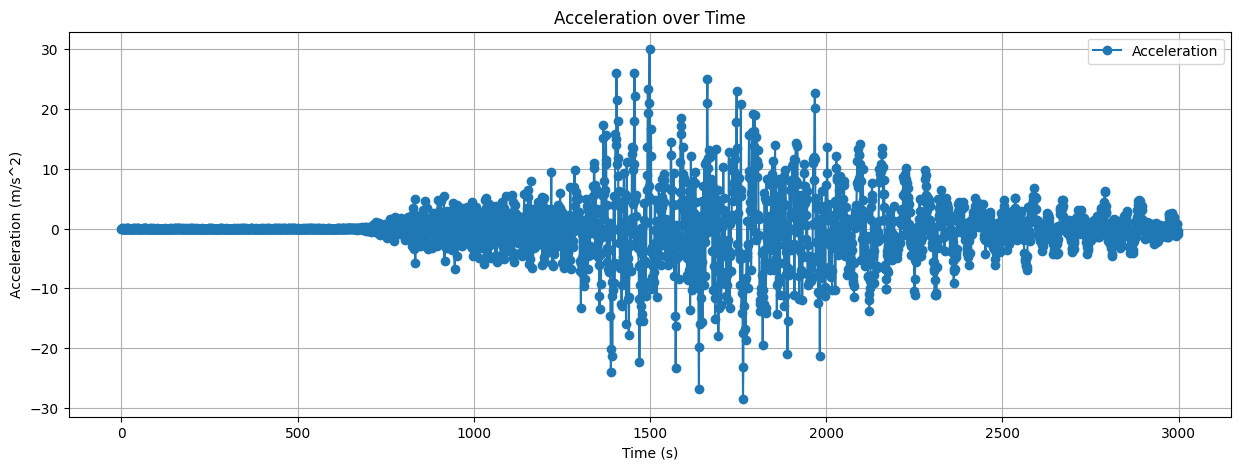

In [11]:
from PythonScripts.visualization import PlotGM

PlotGM(gm_timeseries=ground_motion)

## 3. Split data into patches

Since the length of the ground motion can reach 120s*50Hz = 6000 points, means we have 6000 max input to the model, comparing to an image with $224 height \times 224 weight \times 3 color channels$ = 150,528 points, 25 times of the ground motion data.

In vision transformer(ViT), they split an $224\times 224$ image into $14\times 14$ patches, each patch size is $16\times 16$, data of each patches is $16\times 16\times 3 = 768$, which happend (*which I think is not an accident*) to equal the size of the embedding size of **BERT**(an GPT model).

> **Note:** BERT(Bidirectional Encoder Representations from Transformers, developed by Google in 2008) has an embedding size (also called *Hidden Size*) = 768, which means they use a 768-D vector to represent a single token.

Here we have a hyper-parameter names `PATCH_SIZE`, means the size of our patches after we split the entire ground motion data. e.g. 120s-50Hz has 6000 points, we can split it to 12 patches with 500 `PATCH_SIZE`.

Since our model are going to use 768 as our embedding size (`HIDDEN_SIZE`) which is the same as Vision Transformer and BERT. Of course, you can chagne `HIDDEN_SIZE` to test the proper size to fit our Seismic Transformer, but I think 768 is a good start.

> **Note:** `PATCH_SIZE` is the real representation of the data, `HIDDEN_SIZE` is the virtual representation of the data, when `PATCH_SIZE` = `HIDDEN_SIZE`, it means the dimension doesn't change(ViT). However, when `PATCH_SIZE` < `HIDDEN_SIZE`, means our data dimension increase(BERT).

### 3.1 Caculate the number of patches

In [12]:
# Get the whole points of a single ground motion
GM_Length = train_data.size(1)         # train_data = torch.size([num_of_gms, *length_of_each_gm*, 1])
Num_Of_Classes = train_labels.size()

# Calculate the number of patches
Num_Of_Patch = int(GM_Length / PATCH_SIZE)
print(f"Number of patches (N = {Num_Of_Patch}), with time-series-length (L = {GM_Length}) and patch size (Size = {PATCH_SIZE})")

Number of patches (N = 12), with time-series-length (L = 3000) and patch size (Size = 250)


### 3.2* Visualize the patch process

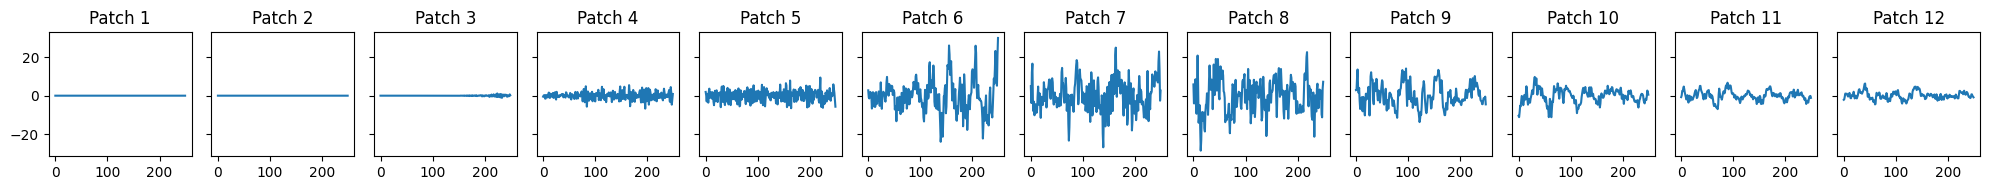

In [13]:
import matplotlib.pyplot as plt

# each points of the subplot
points_per_subplot = int(GM_Length // Num_Of_Patch)

# create the figure and subplot
fig, axes = plt.subplots(nrows=1, ncols=int(Num_Of_Patch), figsize=(20, 2), sharex=True, sharey=True)

# create every subplot
for i in range(int(Num_Of_Patch)):
    start_index = i * points_per_subplot
    end_index = (i + 1) * points_per_subplot if i < Num_Of_Patch - 1 else GM_Length
    axes[i].plot(ground_motion[start_index:end_index])
    axes[i].set_title(f"Patch {i + 1}")

# gap between subplot
plt.tight_layout()

# show the image
plt.show()

### 3.3 Creating patch embedding layer

Using `PatchEmbedding` class to patch the data

* **Input size** = [3000, 1]
* **Output size** = [12, 250]

In [14]:
from PythonScripts.embedding import PatchEmbedding

patch_embedding_layer = PatchEmbedding(Num_Of_Patch, PATCH_SIZE)

# just for test reason
patch_embedding_layer.summary(batch_size=BATCH_SIZE)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [64, 3000, 1]        [64, 12, 250]        --                   --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.77
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.77


#### * Test the patch embedding

In [15]:
print(f"Input groud motion shape: {ground_motion.unsqueeze(0).shape}")
patch_ground_motion = patch_embedding_layer(ground_motion.unsqueeze(0))
print(f"Output patch embedding shape: {patch_ground_motion.shape}")

Input groud motion shape: torch.Size([1, 3000, 1])
Output patch embedding shape: torch.Size([1, 12, 250])


### 3.4 Create Projection Layer

In [16]:
from PythonScripts.embedding import ProjectionModule

projection_layer = ProjectionModule(input_size=PATCH_SIZE, output_size=HIDDEN_SIZE)
projection_layer.summary(batch_size=BATCH_SIZE, num_of_patch=Num_Of_Patch)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ProjectionModule (ProjectionModule)      [64, 12, 250]        [64, 12, 384]        --                   True
├─Linear (up_project)                    [64, 12, 250]        [64, 12, 384]        96,384               True
Total params: 96,384
Trainable params: 96,384
Non-trainable params: 0
Total mult-adds (M): 6.17
Input size (MB): 0.77
Forward/backward pass size (MB): 2.36
Params size (MB): 0.39
Estimated Total Size (MB): 3.51


#### * Test the projection layer

In [17]:
print(f"Input groud motion shape: {patch_ground_motion.shape}")
patch_embedded_ground_motion = projection_layer(patch_ground_motion)
print(f"Output patch embedding shape: {patch_embedded_ground_motion.shape}")

Input groud motion shape: torch.Size([1, 12, 250])
Output patch embedding shape: torch.Size([1, 12, 384])


> **Note:** class token embedding and positional embedding is create in SeT model directly.

## 4. Create a transformer model

#### * Test each module of a transformer

In [18]:
from PythonScripts.transformer import MultiheadSelfAttentionBlock
import PythonScripts.embedding

# MAS_Block instance
MSA_Block = MultiheadSelfAttentionBlock(embedding_dim=HIDDEN_SIZE, 
                                        num_heads=NUM_HEAD, 
                                        attn_dropout=DROPOUT_ATTENTION)
MSA_Block.summary(batch_size=BATCH_SIZE, 
                number_of_patch=Num_Of_Patch, 
                hidden_size=HIDDEN_SIZE)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiheadSelfAttentionBlock (MultiheadSelfAttentionBlock)    [64, 12, 384]        [64, 12, 384]        --                   True
├─LayerNorm (layer_norm)                                     [64, 12, 384]        [64, 12, 384]        768                  True
├─MultiheadAttention (multihead_attn)                        --                   [64, 12, 384]        591,360              True
Total params: 592,128
Trainable params: 592,128
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 1.18
Forward/backward pass size (MB): 2.36
Params size (MB): 0.00
Estimated Total Size (MB): 3.54


In [19]:
from PythonScripts.transformer import MultiLayerPerceptronBlock

# MLP_Block instance
MLP_Block = MultiLayerPerceptronBlock(embedding_dim=HIDDEN_SIZE, 
                                    mlp_size=HIDDEN_SIZE*4, 
                                    dropout=DROPOUT_MLP)
MLP_Block.summary(batch_size=BATCH_SIZE, 
                number_of_patch=Num_Of_Patch, 
                hidden_size=HIDDEN_SIZE)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
MultiLayerPerceptronBlock (MultiLayerPerceptronBlock)   [64, 12, 384]        [64, 12, 384]        --                   True
├─LayerNorm (layer_norm)                                [64, 12, 384]        [64, 12, 384]        768                  True
├─Sequential (mlp)                                      [64, 12, 384]        [64, 12, 384]        --                   True
│    └─Linear (0)                                       [64, 12, 384]        [64, 12, 1536]       591,360              True
│    └─GELU (1)                                         [64, 12, 1536]       [64, 12, 1536]       --                   --
│    └─Dropout (2)                                      [64, 12, 1536]       [64, 12, 1536]       --                   --
│    └─Linear (3)                                       [64, 12, 1536]       [64, 12, 384]        590,208              True
│    └─

In [20]:
from PythonScripts.transformer import TransformerEncoderBlock

# Transformer Encoder
TransformerEncoder = TransformerEncoderBlock(embedding_dim=HIDDEN_SIZE,
                                            num_heads=NUM_HEAD,
                                            mlp_size=HIDDEN_SIZE*4,
                                            mlp_dropout=DROPOUT_MLP,
                                            attn_dropout=DROPOUT_ATTENTION)
TransformerEncoder.summary(batch_size=BATCH_SIZE, 
                number_of_patch=Num_Of_Patch, 
                hidden_size=HIDDEN_SIZE)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [64, 12, 384]        [64, 12, 384]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [64, 12, 384]        [64, 12, 384]        --                   True
│    └─LayerNorm (layer_norm)                      [64, 12, 384]        [64, 12, 384]        768                  True
│    └─MultiheadAttention (multihead_attn)         --                   [64, 12, 384]        591,360              True
├─MultiLayerPerceptronBlock (mlp_block)            [64, 12, 384]        [64, 12, 384]        --                   True
│    └─LayerNorm (layer_norm)                      [64, 12, 384]        [64, 12, 384]        768                  True
│    └─Sequential (mlp)                            [64, 12, 384]        [64, 12, 384]        --                   True
│    │    └─Linear (0)                     

### 4.1 Create a Seismic Transformer

In [21]:
from PythonScripts.transformer import SeismicTransformer

SeT_Example = SeismicTransformer(len_of_gm=GM_Length, # GM_LENGTH: 3000 points (60s - 50Hz)
                        patch_size=PATCH_SIZE, # PATCH_SIZE: 250
                        num_transformer_layers=NUM_LAYER, # number_of_patch: 3000/250
                        embedding_dim=HIDDEN_SIZE, # HIDDEN_SIZE
                        mlp_size=HIDDEN_SIZE*4, # MLP size = HIDDEN_SIZE * 4
                        num_heads=NUM_HEAD, # number of heads in multi-heads
                        attn_dropout=DROPOUT_ATTENTION, # Dropout for attention projection
                        mlp_dropout=DROPOUT_MLP, # Dropout for dense/MLP layers 
                        embedding_dropout=DROPOUT_EMBED, # Dropout for patch and position embeddings
                        num_classes=NUM_OF_CLASSES)

SeT_Example.summary(batch_size=BATCH_SIZE, len_of_gm=GM_Length)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
SeismicTransformer (SeismicTransformer)                      [64, 3000, 1]        [64, 5]              5,376                True
├─PatchEmbedding (patch_embedding)                           [64, 3000, 1]        [64, 12, 250]        --                   --
├─ProjectionModule (projection)                              [64, 12, 250]        [64, 12, 384]        --                   True
│    └─Linear (up_project)                                   [64, 12, 250]        [64, 12, 384]        96,384               True
├─Dropout (embedding_dropout)                                [64, 13, 384]        [64, 13, 384]        --                   --
├─Sequential (transformer_encoder)                           [64, 13, 384]        [64, 13, 384]        --                   True
│    └─TransformerEncoderBlock (0)                           [64, 13, 384]        [64, 13, 384] 

## 5. Train the model

Each epoch combine training and validation. Using training data to update the parameter of the model while the validation data is not.

### 5.1 Define the model, loss function and optimizer

`Loss function` is a method to calculate the loss value, so it can be use either in the train step and validation step. However, `optimizer` is for a specific model by combining the parameter of the target model. Which means we need to declear the model we want to train first and then create a `optimizer` to bind its parameter. *We can't just define a `optimizer` without a target model.*

In [22]:
# Setup the loss function for multi-class classification, can be define everywhere just before the train()
loss_fn = torch.nn.CrossEntropyLoss()

# Declear the target model instance based on SeismicTransfomer, must be before the optimizer declearation
SeT = SeismicTransformer(len_of_gm=GM_Length, # GM_LENGTH: 3000 points (60s - 50Hz)
                        patch_size=PATCH_SIZE, # PATCH_SIZE: 250
                        num_transformer_layers=NUM_LAYER, # number_of_patch: 3000/250
                        embedding_dim=HIDDEN_SIZE, # HIDDEN_SIZE
                        mlp_size=HIDDEN_SIZE*4, # MLP size = HIDDEN_SIZE * 4
                        num_heads=NUM_HEAD, # number of heads in multi-heads
                        attn_dropout=DROPOUT_ATTENTION, # Dropout for attention projection
                        mlp_dropout=DROPOUT_MLP, # Dropout for dense/MLP layers 
                        embedding_dropout=DROPOUT_EMBED, # Dropout for patch and position embeddings
                        num_classes=NUM_OF_CLASSES)

# Define the optimizer for the SeT_Train
optimizer = torch.optim.Adam(params=SeT.parameters(), # if you bind another model you won't undate the target model parameter, so the model won't learn anything
                             lr=LEARNING_RATE, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=WEIGHT_DECAY) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

### 5.2 Train the model

We have define `train_step()` and `validation_step()` then combine them using `train()`, so we just call the `train()` to train our model. Mode detailed setup you can go to `train.py` to see more infomation.

In [23]:
from PythonScripts.train import train

In [24]:
results = train(model=SeT,        # make sure you are training your target model
                train_dataloader=train_dataloader,
                validation_dataloader=validation_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCH,
                device=device)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0612 | train_acc: 0.5331 | validation_loss: nan | validation_acc: 0.5398


### 5.3 Plot the loss and accuracy curve

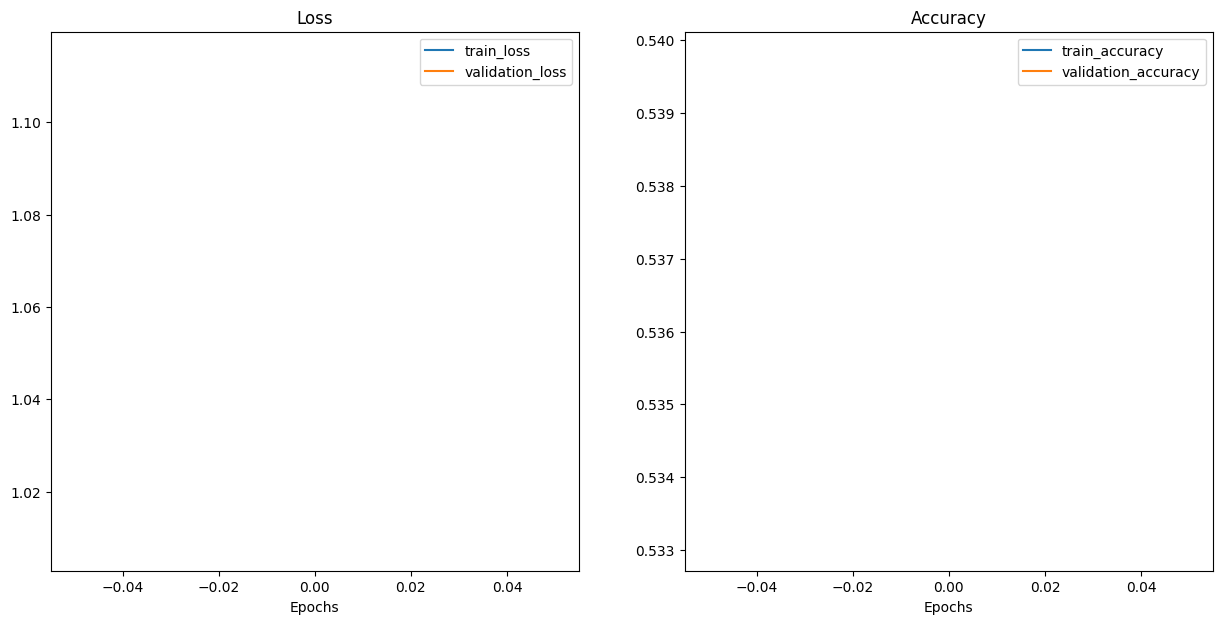

In [25]:
from PythonScripts.visualization import plot_loss_curves

plot_loss_curves(results)

## 6. Test the model

### 6.1 `Test()`

In [26]:
from PythonScripts.train import test

results_test, (y_pred, y_true) = test(model=SeT, dataloader=test_dataloader, device=device)

Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]

### 6.2 Plot the confusion matrix

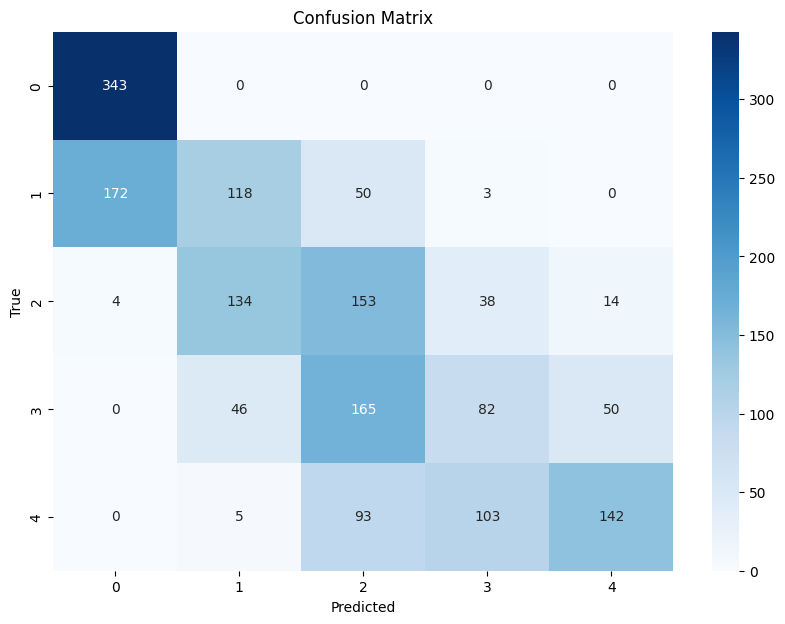

In [28]:
from PythonScripts.visualization import PlotConfusionMatrix

class_names = ["0", "1", "2", "3", "4"]

PlotConfusionMatrix(y_true=y_true, y_pred=y_pred, class_names=class_names)

## 7. Save model

In [29]:
from PythonScripts.utility import SaveModel

SaveModel(model=SeT,
          hidden_size=HIDDEN_SIZE,
          num_of_layer=NUM_LAYER,
          num_of_head=NUM_HEAD,
          num_of_epoch=NUM_EPOCH,
          f1_score=results_test['f1_score'],
          save_mode="params")           # "model", "params", "both"

Model parameters saved to Models\SeT_HS_384_Layer_6_Head_6_Epoch_1_F1_0.49_Params.pth


## 8. Load Model

In [33]:
from PythonScripts.utility import LoadModel, LoadModelParams

model = LoadModel(model_name='SeT_HS_384_Layer_6_Head_6_Epoch_1_F1_0.56_Model.pth')

model = LoadModelParams(model=model,params_name='SeT_HS_384_Layer_6_Head_6_Epoch_1_F1_0.56_Params.pth')

> **Note:** That's all! Congradulation!
>